In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#constantes
Kb = 8.6173324e-5

SIZE = 3
TEMPERATURAS = [i for i in np.arange(250,350.1,0.1)]
TEMPERATURA = 250
STEP = 1

E_A = 0
E_B = 0
E_AA = -0.1
E_BB = -0.2
E_AB = -0.3
N_A = 9
N_B = (SIZE * SIZE) - N_A
E_on_site = N_A * E_A + N_B * E_B

N_A_range = np.array([n for n in np.arange(0,N_A+STEP,STEP)]) # 1 A size**2
N_A_percentage = N_A_range/(N_A + N_B)

In [3]:
def possible_matrices(size, N_a, N_b):
    """
    size: matrix order
    N_a: number of 'A's to be placed
    N_b: number of 'B's to be placed
    """
    
    # Check if the total number of elements matches the sum of N_a and N_b
    if N_a + N_b != size * size:
        raise ValueError("The total number of 'A's and 'B's should match the size of the matrix.")
    
    # If N_a is zero, directly create a matrix filled with 'B's
    if N_a == 0:
        return np.full((1, size, size), 'B', dtype='<U1')
    
    # Generate all possible combinations of indices for 'A's
    indices_A = np.array(list(itertools.combinations(range(size*size), N_a)))
    
    # Generate matrices with 'B's filled in all cells
    matrices = np.full((len(indices_A), size, size), 'B', dtype='<U1')
    
    # Iterate through all possible combinations of indices for 'A's
    for i, indices in enumerate(indices_A):
        # Fill 'A's at specified indices
        indices = np.unravel_index(indices, (size, size))
        matrices[i][indices] = 'A'
    
    #print(len(matrices))
    return matrices


In [4]:
def determinar_vizinhos(matriz):
    """ Essa função fornece um dicionário que relaciona todos os elementos na célula
    a seus vizinhos, tanto os de dentro da célula quanto os de células vizinhas iguais.
    
    Args:
    
        matriz: a célula da qual queremos saber os elementos e seus vizinhos
        
    Return:
    
        vizinhos: um dicionário com as chaves sendo as coordenadas da matriz e os valores os vizinhos dessa coordenada"""
    
    vizinhos = {}
    linhas, colunas = matriz.shape

    for i, j in itertools.product(range(linhas), range(colunas)):
        vizinhos[(i, j)] = []

        # Vizinhos à direita e abaixo
        det_vizinhos = lambda x, y: vizinhos[(i, j)].append(matriz[x, y])
        if j < colunas - 1: det_vizinhos(i, j + 1)
        if i < linhas - 1: det_vizinhos(i + 1, j)

        # Vizinhos nas bordas
        if j == 0: det_vizinhos(i, colunas - 1)
        if j == colunas - 1: det_vizinhos(i, 0)
        if i == 0: det_vizinhos(linhas - 1, j)
        if i == linhas - 1: det_vizinhos(0, j)

    return vizinhos


In [5]:
def energia_total(matriz, E_AB, E_AA, E_BB, E_on_site):
    """ Esta função calcula a energia de cada vizinho e a energia total da célula.
    
    Args:
        matriz: configuração da célula.
        E_AB: energias entre os elementos A e B.
        E_AA: energias entre os elementos A e A.
        E_BB: energias entre os elementos B e B.
        E_on_site: energia para o próprio sítio.
        
    Return:
        energia_célula: energia total da configuração da célula.
        energias_vizinhos: lista com os valores de energia entre cada vizinho.
    """
    vizinhos_dict = determinar_vizinhos(matriz)
    energias_vizinhos = np.array([])

    for coordenada, vizinhos in vizinhos_dict.items():
        i, j = coordenada
        elemento = matriz[i, j]
        vizinhos = np.array(vizinhos)

        # Energia entre o elemento e seus vizinhos
        energia_elemento_vizinhos = np.where(elemento != vizinhos, E_AB, 
                                              np.where(elemento == 'A', E_AA, E_BB))
        energias_vizinhos = np.concatenate((energias_vizinhos, energia_elemento_vizinhos))

    energia_célula = np.sum(energias_vizinhos) + E_on_site
    return energia_célula

In [6]:
def helmholtz(energias, temperatura):
    """Essa função calcula o valor da função de partição
    
    Args:
        
        energias: lista com a energia de cada configuração da célula.
        temperatura: temperatura na qual estaria a célula.
        
    Return:
    
        Z: valor da função de partição em uma temperatura.
    """
    beta = 1.0 / (Kb * temperatura)
    Z = 0.0
    for energia in energias:
        Z += np.exp(-beta * energia)

    F = -(Kb * temperatura) * np.log(Z)
    
    return F

In [7]:
def analise(size, N_A, N_B, E_AB, E_AA, E_BB, temperaturas):
    """Essa função realiza toda a análise de caso
    
    Args:
        N_A: número de átomos A.
        N_B: número de átomos B.
        n: ordem da célula quadrada.
        E_AB: energia entre A e B.
        E_AA: energia entre A e A.
        E_BB: energia entre B e B.
        temperatura: intervalo de temperatura em que analisaremos a célula.
        
    Return:
    
        data: dataframe com as informações de temperatura e energia livre de helmholtz.
    """
    energias = []
    lista_helm = []
    celulas = possible_matrices(size, N_A, N_B)
    
    for cell in celulas:
        energia_celula = energia_total(cell, E_AB, E_AA, E_BB,E_on_site)
        energias.append(energia_celula)
    
    for T in temperaturas:
        F = helmholtz(energias, T)
        lista_helm.append(F)
    
    data = pd.DataFrame({"Temperatura": temperaturas, "Energia de Helmholtz": lista_helm})
    return data

In [8]:
df_helmholtz = analise(SIZE, N_A, N_B, E_AB, E_AA, E_BB, TEMPERATURAS)
df_helmholtz

,Temperatura,Energia de Helmholtz
0,250.0,-2.4
1,250.1,-2.4
2,250.2,-2.4
3,250.3,-2.4
4,250.4,-2.4
...,...,...
997,349.7,-2.4
998,349.8,-2.4
999,349.9,-2.4
1000,350.0,-2.4


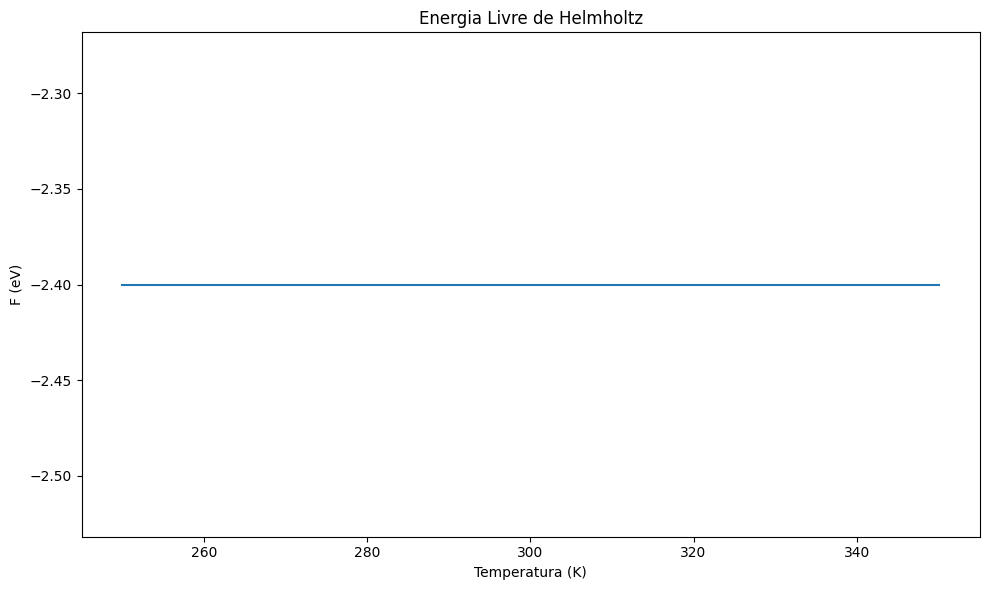

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_helmholtz, x=df_helmholtz['Temperatura'], y=df_helmholtz['Energia de Helmholtz'])
sns.color_palette("Paired")
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('F (eV)')
plt.tight_layout()
# fig.get_figure() #'pega' o gráfico para salvar
# fig.savefig("helmholtz.pdf") #salva o gráfico 

### Playground

In [10]:
def calcular_vizinhos_v1(matriz):
    linhas, colunas = matriz.shape
    vizinhos = {}

    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    indices = itertools.product(range(linhas), range(colunas))

    for i, j in indices:
        vizinhos[(i, j)] = []

        # Calculate indices of neighboring elements
        neighbor_indices = (np.array([i, j]) + offsets) % np.array([linhas, colunas])

        # Add neighbors to the current element
        for ni, nj in neighbor_indices:
            vizinhos[(i, j)].append(matriz[ni, nj])

    return vizinhos

# Example usage
matriz = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])
vizinhos = calcular_vizinhos_v1(matriz)
print(vizinhos)


{(0, 0): [2, 4, 3, 7], (0, 1): [3, 5, 1, 8], (0, 2): [1, 6, 2, 9], (1, 0): [5, 7, 6, 1], (1, 1): [6, 8, 4, 2], (1, 2): [4, 9, 5, 3], (2, 0): [8, 1, 9, 4], (2, 1): [9, 2, 7, 5], (2, 2): [7, 3, 8, 6]}


In [11]:
import numpy as np

def determinar_vizinhos_v2(matrix, size):
    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    i, j = np.indices((size, size))

    # Reshape offsets to have an extra dimension for broadcasting
    reshaped_offsets = offsets.reshape(1, 1, -1, 2)

    # Calculate indices of neighboring elements
    neighbor_indices = (i[..., np.newaxis, np.newaxis] + reshaped_offsets) % np.array([size, size])

    # Create a dictionary to store neighbors
    vizinhos = {(x, y): [matrix[neighbor_indices[x, y, k, 0]][neighbor_indices[x, y, k, 1]] for k in range(neighbor_indices.shape[2])] for x in range(size) for y in range(size)}

    return vizinhos

matriz_teste = [['AA', 'AB', 'BB'], ['AB', 'BB', 'BB'], ['BB', 'BB', 'BB']]
determiar_vizinho = determinar_vizinhos_v2(matriz_teste, 3)
print(determiar_vizinho)


{(0, 0): ['AB', 'AB', 'BB', 'BB'], (0, 1): ['AB', 'AB', 'BB', 'BB'], (0, 2): ['AB', 'AB', 'BB', 'BB'], (1, 0): ['BB', 'BB', 'AB', 'AB'], (1, 1): ['BB', 'BB', 'AB', 'AB'], (1, 2): ['BB', 'BB', 'AB', 'AB'], (2, 0): ['BB', 'BB', 'BB', 'BB'], (2, 1): ['BB', 'BB', 'BB', 'BB'], (2, 2): ['BB', 'BB', 'BB', 'BB']}
